<a href="https://colab.research.google.com/github/daspartho/fastai-part2/blob/main/matmul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pathlib import Path
import pickle, gzip
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'

In [3]:
from urllib.request import urlretrieve
if not path_gz.exists():
    urlretrieve(MNIST_URL, path_gz)

In [4]:
!ls -l data

total 16656
-rw-r--r-- 1 root root 17051982 Oct 20 15:49 mnist.pkl.gz


In [5]:
with gzip.open(path_gz, 'rb') as f:
    (x_train, y_train), (x_valid, y_valid), _ = pickle.load(f, encoding='latin-1')

In [6]:
type(x_train)

numpy.ndarray

In [7]:
ls1 = list(x_train[0])
vals = ls1[200:210]
vals

[0.0,
 0.0,
 0.0,
 0.19140625,
 0.9296875,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125]

In [8]:
def chunks(x, sz):
    for i in range(0, len(x), sz):
        yield x[i: i+sz]

In [9]:
type(chunks(vals, 5))

generator

In [10]:
list(chunks(vals, 5))

[[0.0, 0.0, 0.0, 0.19140625, 0.9296875],
 [0.98828125, 0.98828125, 0.98828125, 0.98828125, 0.98828125]]

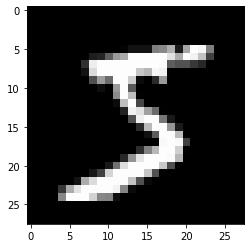

In [11]:
mpl.rcParams['image.cmap'] = 'gray'
plt.imshow(list(chunks(ls1, 28)))

In [12]:
from itertools import islice

In [26]:
it = iter(vals)
it

In [27]:
list(islice(it, 5))

[0.0, 0.0, 0.0, 0.19140625, 0.9296875]

In [28]:
it = iter(ls1)
img = list(iter(lambda: list(islice(it, 28)), []))

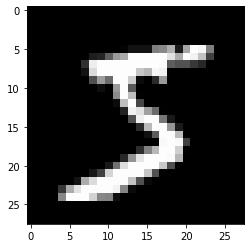

In [29]:
plt.imshow(img)

In [30]:
img[20][15]

0.98828125

In [31]:
class Matrix:
    def __init__(self, xs):
        self.xs = xs
    def __getitem__(self, idxs):
        return self.xs[idxs[0]][idxs[1]]

In [32]:
m = Matrix(img)
m[20, 15]

0.98828125

In [33]:
import torch
from torch import tensor

In [34]:
tensor(vals)

tensor([0.0000, 0.0000, 0.0000, 0.1914, 0.9297, 0.9883, 0.9883, 0.9883, 0.9883,
        0.9883])

In [35]:
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))
x_train.shape

torch.Size([50000, 784])

In [37]:
x_train.type()

'torch.FloatTensor'

In [38]:
imgs = x_train.reshape(-1, 28, 28)
imgs.shape

torch.Size([50000, 28, 28])

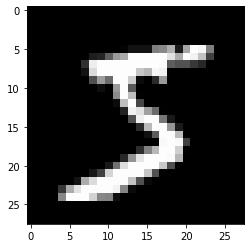

In [39]:
plt.imshow(imgs[0])

In [40]:
imgs[0,20,15]

tensor(0.9883)

In [44]:
y_train, y_train.shape

(tensor([5, 0, 4,  ..., 8, 4, 8]), torch.Size([50000]))

In [45]:
y_train.min(), y_train.max()

(tensor(0), tensor(9))